# **Unsupervised/Semi-supervised Learning**
### CA3 - Final Project - Machine Learning Module
### Group Work

In [2]:
# Add libaries here if needed
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

import tensorflow as tf

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.cluster import AgglomerativeClustering

import scipy.cluster.hierarchy as sch

from google.colab import drive

pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format
sns.set_theme(style="white")

%matplotlib inline

## **Questions 1: Individual work contributions**
Ademola: 
- Work on importing the customer_data.csv (due some issues regarding the file, Karla submit the file in a public repository for an easier access).
- Working on pre-processing methods (Karla added log transformation before normalisation of data, to deal with skeweness).
- K-means clustering on customer dataset.
- Plottings to visualize bend for select number of clusters (Karla added BCSS vs Clusters plot).
- Create visualization to select number of clusters (Karla helped, also applied PCA for 3D visualization).

Caroline: 
- Hierarchical clustering modelling and visualization.
- Import MNIST dataset from inbuilt library.
- Explore MNIST dataset and visualize 10 images from each class.

Cibin:
- Imported the mnist dataset and used SOM to create the map.
- Pre-prosessing data for SOM.
- Reserach on SOM for code examples.
- Perform Self Orginzed Map using MiniSom library.

Karla: 
- Planned on distribution of workload for each member.
- Prepared shared folders and files to work on Google Colab.
- Reserach on LSTM for code examples
- Perform classification using LSTM (Keras).
- Preparing final file for submition.

## **Question 2: K-means and Hierarchical clustering**

### Write a python code to extract the Customer_data.csv

In [31]:
# Location of dataset into google drive, make sure to mount driver before, see above.
# MODIFICATION: as a group we had some problems accessing CSV file in shared location on Google Drive. 
#     Karla created a public repository for easy accesss.
data_url = r'https://machinelearning.tanniestudio.com/CA3/Customer_data.csv'

# Reading data from CSV file.
data = pd.read_csv(data_url)
data.head()

,Channel,Area,Vegetables,Dairy,Grocery,Frozen,Cleaning,Dessert
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


### Perform any pre-processing method to normalise the dataset. Give reason why the normalisation is important in context of clustering

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Channel     440 non-null    int64
 1   Area        440 non-null    int64
 2   Vegetables  440 non-null    int64
 3   Dairy       440 non-null    int64
 4   Grocery     440 non-null    int64
 5   Frozen      440 non-null    int64
 6   Cleaning    440 non-null    int64
 7   Dessert     440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


By looking at the metadata, Channel and Area are categorical variables:
- Area indicates customers' region: Dundalk(1), Drogheda(2), Cavan(3).
- Channel indicates where customers did shop: Hotel/Restaurant/Cafe(1) or Retail(2).

These features would be excluded from the clustering process. The function info() indicates that Channel and Area are int type, therefore I will convert these features into objects (as these are categorical).

In [32]:
# Convert into type str.
print('Channel values:', set(data.Channel.unique()))
print('Arae values:', set(data.Area.unique()))

data['Channel'] = data['Channel'].astype(object)
data['Area'] = data['Area'].astype(object)

Channel values: {1, 2}
Arae values: {1, 2, 3}


In [33]:
data.columns

Index(['Channel', 'Area', 'Vegetables', 'Dairy', 'Grocery', 'Frozen',
       'Cleaning', 'Dessert'],
      dtype='object')

In [34]:
columns = ['Vegetables', 'Dairy', 'Grocery', 'Frozen', 'Cleaning', 'Dessert']

To apply normalization, the following has to be true [7]:
- Data has a Gaussian distribution.
- The Data set lacks enough data to create quantiles.

First of all, I will check if the distribution of the features 'Vegetables', 'Dairy', 'Grocery', 'Frozen', 'Cleaning', and 'Dessert' is normal (i.e., gaussian, bell shape). First, let's look at the distribution by looking at a boxplot.

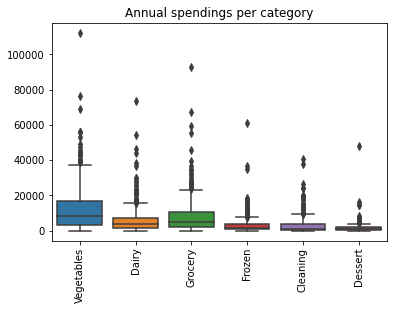

In [ ]:
sns.boxplot(data=data[columns])
plt.title("Annual spendings per category")
plt.xticks(rotation=90)
plt.show()

Data looks skewed, therefore we need to apply transformation (log). Let's get the list of the features that are strongly skewed and then apply log transformation.

In [35]:
# Get a list of features which have strong skewness
sk_data = pd.DataFrame(data.iloc[:,2:].skew(axis=0))

sk_condition = (sk_data.loc[:,0]<1) & (sk_data.loc[:,0]>(-1))

sk_features = sk_data[~sk_condition].index.values
sk_features

array(['Vegetables', 'Dairy', 'Grocery', 'Frozen', 'Cleaning', 'Dessert'],
      dtype=object)

In [36]:
# Transforming data
data_trans = data.copy()
data_trans.loc[:,sk_features] = np.log(data_trans.loc[:,sk_features]+1)
data_trans.head()

,Channel,Area,Vegetables,Dairy,Grocery,Frozen,Cleaning,Dessert
0,2,3,9.4,9.2,8.9,5.4,7.9,7.2
1,2,3,8.9,9.2,9.2,7.5,8.1,7.5
2,2,3,8.8,9.1,8.9,7.8,8.2,9.0
3,1,3,9.5,7.1,8.3,8.8,6.2,7.5
4,2,3,10.0,8.6,8.9,8.3,7.5,8.6


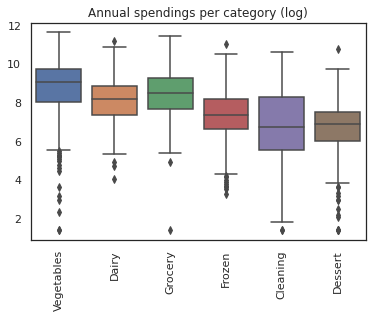

In [37]:
sns.boxplot(data=data_trans[columns])
plt.title("Annual spendings per category (log)")
plt.xticks(rotation=90)
plt.show()

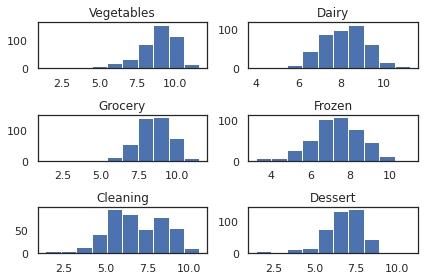

In [38]:
fig, ax = plt.subplots(3,2)
col = 0
row = 0

for i in columns:
  ax[row,col].hist(data_trans[i])
  ax[row,col].set_title(i)
  
  if col == 1:
    row+=1
    col=0
  else:
    col=+1

plt.tight_layout()
plt.show()

Now, the data looks way better. Distribution looks ok, let's normalize the data.

In [39]:
data_std = StandardScaler().fit_transform(data_trans[columns])
data_std = pd.DataFrame(data_std, columns=data[columns].columns)
data_std.head()

,Vegetables,Dairy,Grocery,Frozen,Cleaning,Dessert
0,0.5,1.0,0.4,-1.5,0.6,0.4
1,0.1,1.0,0.7,0.1,0.8,0.6
2,0.0,0.9,0.5,0.4,0.8,1.8
3,0.5,-1.0,-0.1,1.1,-0.3,0.6
4,0.9,0.4,0.4,0.8,0.4,1.5


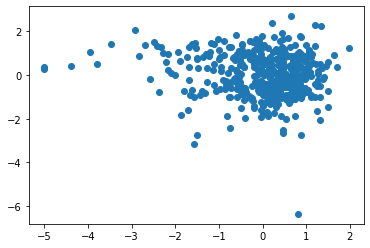

In [ ]:
plt.scatter(data_std['Vegetables'], data_std['Grocery'])
plt.show()

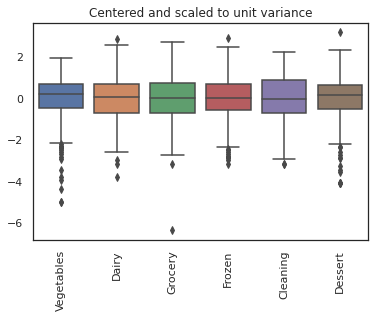

In [40]:
sns.boxplot(data=data_std[columns])
plt.title("Centered and scaled to unit variance")
plt.xticks(rotation=90)
plt.show()

In the context of clustering, normalization is important because:
- K-mean clustering computes the similarity by combining features. The data is required to be on the same scale. As a way to make features "unitless", we get the z-score to normalize the data.
- As k-means clustering tends to produce a circular shape (isotropic), this could help to leave unequal variables, this will tend to be separated along with variables with greater variance (more circular shape).
- Additionally, there would be less computation when calculating weights and distances.


### Perform K-means clustering on the dataset.

As the metadata from the dataset says that this information comes from a specific channel and specific area, when clustering the annual costs variables (Vegetables, Dairy, Grocery, Frozen, cleaning, and Dessert), these variables could be a cluster in 2 (channels) or 3 (areas). So, initially, I will start with 3 clusters, however, I would have created a scree plot to visualize the "Elbow" and decide on how many clusters to use first.

In [41]:
# Transform to array
X = data_std.values

In [ ]:
# Cluster normalized and reduced data
kmeans = KMeans(3, random_state=0)
cluster = kmeans.fit_predict(X)

In [ ]:
# Save cluster into original data
data['Cluster'] = cluster
data.head()

,Channel,Area,Vegetables,Dairy,Grocery,Frozen,Cleaning,Dessert,Cluster
0,2,3,12669,9656,7561,214,2674,1338,1
1,2,3,7057,9810,9568,1762,3293,1776,1
2,2,3,6353,8808,7684,2405,3516,7844,1
3,1,3,13265,1196,4221,6404,507,1788,0
4,2,3,22615,5410,7198,3915,1777,5185,1


### Plot WCSS vs Clusters and BCSS Vs Clusters graph to visualise and use elbow method to select number of centroids.

In [ ]:
wcss = []
bcss = []
n_ks = 10 # Number of times I will create a KMeans model to compare to others and show sceen plot to select cluster using elbow method.
n_components = range(1, n_ks+1)

for i in n_components:
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=16)
    kmeans.fit(X)

    # For wcss
    # inertia_ returns the Sum of squared distances of samples to their closest cluster center.
    wcss.append(kmeans.inertia_) 

    # For bcss
    # The Between the Cluster Sum of Squares (BCSS), 
    #    measure the sum of the squares of the Euclidean distance between all cluster centers
    values, counts = np.unique(kmeans.labels_, return_counts = True)
    mean_data = np.mean(X, axis=0)
    diff = np.linalg.norm(kmeans.cluster_centers_ - mean_data, axis=1)    
    diff_sq = np.power(diff, 2)
    BCSS = sum(counts * diff_sq)

    bcss.append(BCSS)

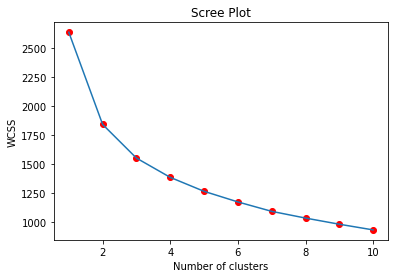

In [ ]:
# Plot WCSS 
fig, ax = plt.subplots()
plt.plot(n_components, wcss)
plt.scatter(n_components, wcss, color='red')
plt.title('Scree Plot')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

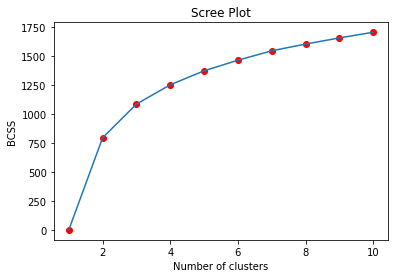

In [ ]:
# Plot BCSS
fig, ax = plt.subplots()
plt.plot(n_components, bcss)
plt.scatter(n_components, bcss, color='red')
plt.title('Scree Plot')
plt.xlabel('Number of clusters')
plt.ylabel('BCSS')
plt.show()

It seems that there is an "elbow" in Cluster number "Two", as after cluster three there are no big changes on WCSS and BCSS plots.

In [ ]:
# Cluster normalized and reduced data
kmeans = KMeans(2, random_state=0)
cluster = kmeans.fit_predict(X)

data['Cluster'] = cluster
display(data.head())

,Channel,Area,Vegetables,Dairy,Grocery,Frozen,Cleaning,Dessert,Cluster
0,2,3,12669,9656,7561,214,2674,1338,0
1,2,3,7057,9810,9568,1762,3293,1776,0
2,2,3,6353,8808,7684,2405,3516,7844,0
3,1,3,13265,1196,4221,6404,507,1788,1
4,2,3,22615,5410,7198,3915,1777,5185,0


### Perform meaningful observations through visualisation on the obtained k-means clustering.

PCA in conjunction with k-means is a powerful method for visualizing high dimensional data. As the dataset is made up of more than 3 variables, I am going to use PCA to reduce dimensionality and plot the data.

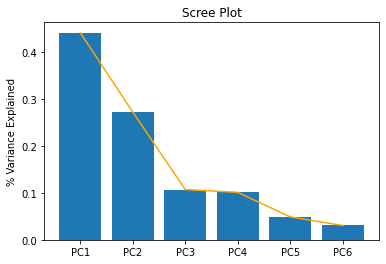

In [ ]:
# Compute principal components by taking the number of variables. 
# Transformation and standarization is done.
n_comp = len(X[0]) # 6 variables
pca = PCA(n_components=n_comp).fit(X)

# Plot scree plot to see the "elbow" and choose the num. of principal components.
col_PCs = ['PC' + str(x) for x in range(1, pca.n_components_+1)]    
PCs_exp = pd.Series(pca.explained_variance_ratio_, index=col_PCs)
fig, ax = plt.subplots()
plt.bar(col_PCs, PCs_exp)
plt.plot(col_PCs, PCs_exp, color='orange')
plt.title("Scree Plot")
plt.ylabel("% Variance Explained")
plt.show()

In [51]:
# There is a variance drop-off in PC3. Based on this bend, I am going to chose PC3 for clustering.
# PC3 explained roughly 80% of the variability of the data, good proportion.
reduced_data = PCA(n_components=3).fit_transform(X)

# Display information in DataFrame
data_reduced = pd.DataFrame(reduced_data, columns=['PC1', 'PC2', 'PC3'])
data_reduced.head()

,PC1,PC2,PC3
0,-1.4,0.3,-0.2
1,-1.4,-0.5,0.1
2,-1.5,-1.2,1.0
3,0.8,-1.2,0.3
4,-0.8,-1.8,0.3


In [ ]:
# Visualize clusters
fig = go.Figure(data=[go.Scatter3d(
    x=data_reduced['PC1'],
    y=data_reduced['PC2'],
    z=data_reduced['PC3'],
    mode='markers',
    marker=dict(
        size=10,
        color=data['Cluster'],  # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)])

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0),
                  scene = dict(
                    xaxis_title='PC1',
                    yaxis_title='PC2',
                    zaxis_title='PC3'),)

fig.show()

### Perform Hierarchical clustering. 

To find the number of clusters to do hierarchial clustering drawing a dendrogram is easy to find a dendrogram used to undersyand the realationship between the variables.

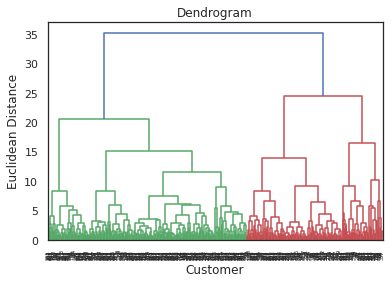

In [42]:
dendrogram = sch.dendrogram(sch.linkage(X, method='ward'))
plt.title("Dendrogram")
plt.xlabel("Customer")
plt.ylabel("Euclidean Distance")
plt.show()

#in the figure the x axis denotes the samples and the y axis denotes the distance

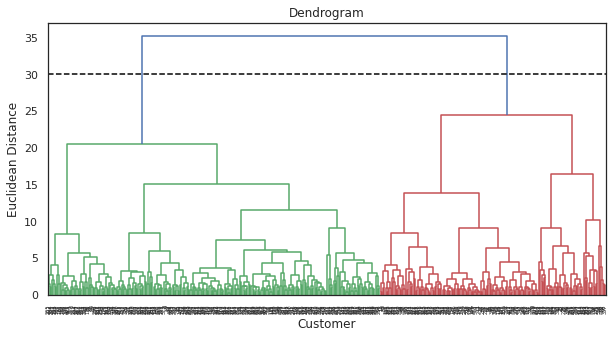

In [50]:
#the blue lines helps determine the thereshold . In this case we can consider 30 and cut
plt.figure(figsize=(10,5))
dendrogram = sch.dendrogram(sch.linkage(X, method='ward'))

#to cut the dendrogram at the threshold
plt.axhline(y=30, color='black', linestyle='--')
plt.title("Dendrogram")
plt.xlabel("Customer")
plt.ylabel("Euclidean Distance")
plt.show()

From the above figure it shows that the line cuts at 2 points and so we can perform hierarchial clustering with 2 clusters using agglomerative clustering.

In [46]:
agg = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
clusters_hc = agg.fit_predict(X)

#the array consists of 0's and 1's since we fixed the number of clusters as 2
#0 denotes the 1st cluster and 1 denostes the 2nd cluster

Using a scatterplot to visualize the clusters between any 2 variables

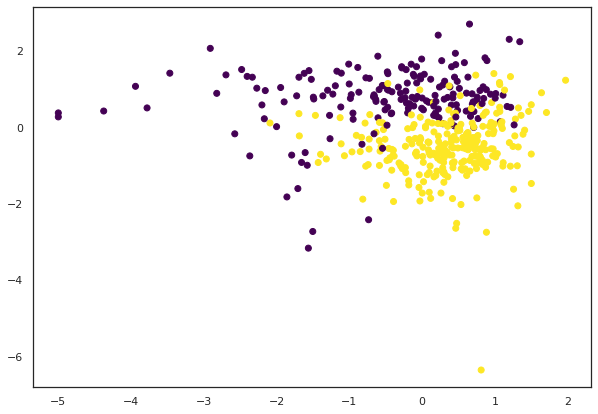

In [54]:
plt.figure(figsize=(10,7))
plt.scatter(data_std.iloc[:,0], data_std.iloc[:,2], c=clusters_hc, cmap='viridis')
plt.show()

Also, we can use PCA to reduce dimentionality and visualize the two clusters.

In [52]:
# Visualize clusters
fig = go.Figure(data=[go.Scatter3d(
    x=data_reduced['PC1'],
    y=data_reduced['PC2'],
    z=data_reduced['PC3'],
    mode='markers',
    marker=dict(
        size=10,
        color=clusters_hc,  # set color to an array/list of desired values from hierarchial clustering
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)])

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0),
                  scene = dict(
                    xaxis_title='PC1',
                    yaxis_title='PC2',
                    zaxis_title='PC3'),)

fig.show()

### Comment on differences between K-means and Hierarchical clustering.
- In k-means clustering, it is needed to know in advance the number of clusters to divide the data.
- In hierarchical clustering, you can stop at any number of clusters, and find appropriate number of clusters by interpreting  the dendrogram.
- In k-means clustering, this can use median or mean as a cluster centre to represent each cluster.
- In hierarchical clustering, Agglomerative methods is begin with k clusters and sequentially combine similar clusters until only one cluster is obtained.

## **Question 4: MNIST Dataset**

### Write a python code to download/extract MNIST data set.

In [3]:
def basic_statistics(data):

  print("==============================================================")
  print("Basic statistics")
  print("==============================================================")
  print("About images:")
  print("Max value:", data.max())
  print("Min value:", data.min())
  print("Missing values:", np.isnan(data).sum())
  print("Count items:", len(data), end='\n\n')

def get_example_classes(df_xtrain_, df_ytrain_, num_classes_):
  # This method prints the images of the datasets, selecting random images per category.
  # Get random image in dataset for each class
  lst = []
  for i in np.arange(0,num_classes_):
    result = np.where(df_ytrain_ == i)
    lst.append(np.random.choice(result[0]))

  # Plotting images
  plt.figure(figsize=(8,3.5))
  for i in lst:
      plt.subplot(2, 5, lst.index(i)+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(df_xtrain_[i], cmap=plt.cm.binary)
      
  plt.show()

def split_dataset(df_, features_, label_, test_size_, display_=True):
  
  X_train, X_test, y_train, y_test = train_test_split(df_[features_], df_[label_], test_size = test_size_)

  concat = lambda x,y: pd.concat([pd.DataFrame(x), pd.DataFrame(y)], axis=1)

  df_train = concat(X_train, y_train)
  df_test = concat(X_test, y_test)

  if display_:
    print('Length dataset', len(df_))
    print('Train subset', len(df_train))
    print('Test subset', len(df_test))

  return df_train, df_test

In [4]:
# inbuilt MNIST dataset in tensorflow
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


### Explore the dataset

We are going to start by looking at basic statistics data regarding images.

In [ ]:
basic_statistics(x_train)

Basic statistics
About images:
Max value: 255
Min value: 0
Missing values: 0
Count items: 60000



In [ ]:
basic_statistics(x_test)

Basic statistics
About images:
Max value: 255
Min value: 0
Missing values: 0
Count items: 10000



In [ ]:
print('train dataset images:', len(x_train), '\ntest dataset images:', len(x_test), '\ntotal images:', len(x_train)+len(x_test))

train dataset images: 60000 
test dataset images: 10000 
total images: 70000


By looking at the basic statistics:
- Max and Min values from images are ok, as RGB images values are from [0,255]
- Unique values in the label variable are ok, as it is 10 values from [0,9]
- No missing values
- The dataset is balanced, as shown in the figure the number of images in each class is the same

Visualization of images on train dataset

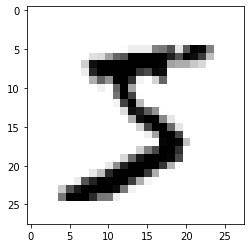

In [ ]:
#plottin gthe graph
plt.imshow(x_train[0], cmap=plt.cm.binary)
plt.show()

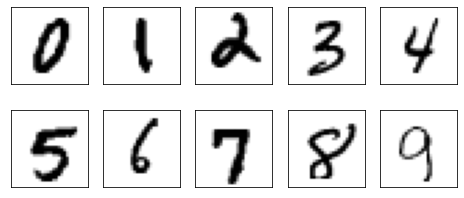

In [ ]:
get_example_classes(x_train, y_train, 10)

### Use unlabelled training data and split it into training and validation data. 
- For SOM, a data pre-processing has to be done before modelling where normalization is performed.
- For LSTM, validation split would be used when training model. Not needed to split train dataset into train and validation as when modelling a percentage will be specified (e.g., model.fit(validation_split=0.2)).

### Use Self-Organising Mapsto learn the topology of the dataset. See if you can imporive the SOM learning by starting with K-means.

Installing the SimpSOM which is the SOM library that we are gonna use to map the values to the output vectors.

In [1]:
# Importing library for SOM
!pip install SimpSOM

  Created wheel for SimpSOM: filename=SimpSOM-1.3.4-cp37-none-any.whl size=17086 sha256=20c52064c569c4cc07f3d5a5fa819b4209f97347f72283141415a9aed5d13f59
  Stored in directory: /root/.cache/pip/wheels/51/76/ee/c02f0bc20af4cd8f46ee4142ebf7bb654b737d6d8f2360d26b
Successfully built SimpSOM


In [3]:
import SimpSOM as sps
from pydrive.auth import GoogleAuth #importing file from drive
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [5]:
#Here we first define a few useful functions
def posCount(x,y):
     return y*40+x

def posCountR(x):
     return [np.int(x%40),np.int(x/40)]

In [6]:
auth.authenticate_user() #autheticating user
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Data preprocessing

In [7]:
downloaded = drive.CreateFile({'id':"16i3z-TO9GAiiUs9xv9nkvz2HZ-6RaO39"})   #downloading the file from drive to colab.
downloaded.GetContentFile('mnist_train.csv')

In [13]:
train = pd.read_csv("mnist_train.csv") #laoding the mnist train data to train df
print(len(train))

60000


In [14]:
display(train) #print out the dataframe 

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,1x10,1x11,1x12,1x13,1x14,1x15,1x16,1x17,1x18,1x19,1x20,1x21,1x22,1x23,1x24,1x25,1x26,1x27,1x28,2x1,2x2,2x3,2x4,2x5,2x6,2x7,2x8,2x9,2x10,2x11,...,27x17,27x18,27x19,27x20,27x21,27x22,27x23,27x24,27x25,27x26,27x27,27x28,28x1,28x2,28x3,28x4,28x5,28x6,28x7,28x8,28x9,28x10,28x11,28x12,28x13,28x14,28x15,28x16,28x17,28x18,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,147,252,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
59996,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
59997,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
59998,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Exploration

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



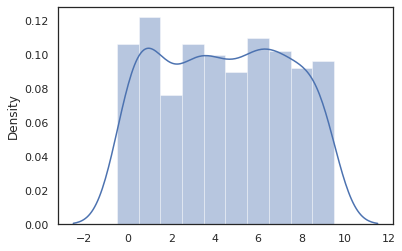

In [15]:
train = train.sample(n=500, random_state=0) #Using the 500 samples for analysis.
labels = train['label']
train = train.drop("label",axis=1) #Creating the data sets.

#to see if the data is normally distributed
sns.distplot(labels.values,bins=np.arange(-0.5,10.5,1))

# Normalising the data
trainSt = StandardScaler().fit_transform(train.values)

From the Dist plot above we can see the values are of almost equal propotions. And there is no significant drop in density of a variable.

In [16]:
trainSt

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Building SOM model

Periodic Boundary Conditions active.
The weights will be initialised with PCA.
Training SOM... done!


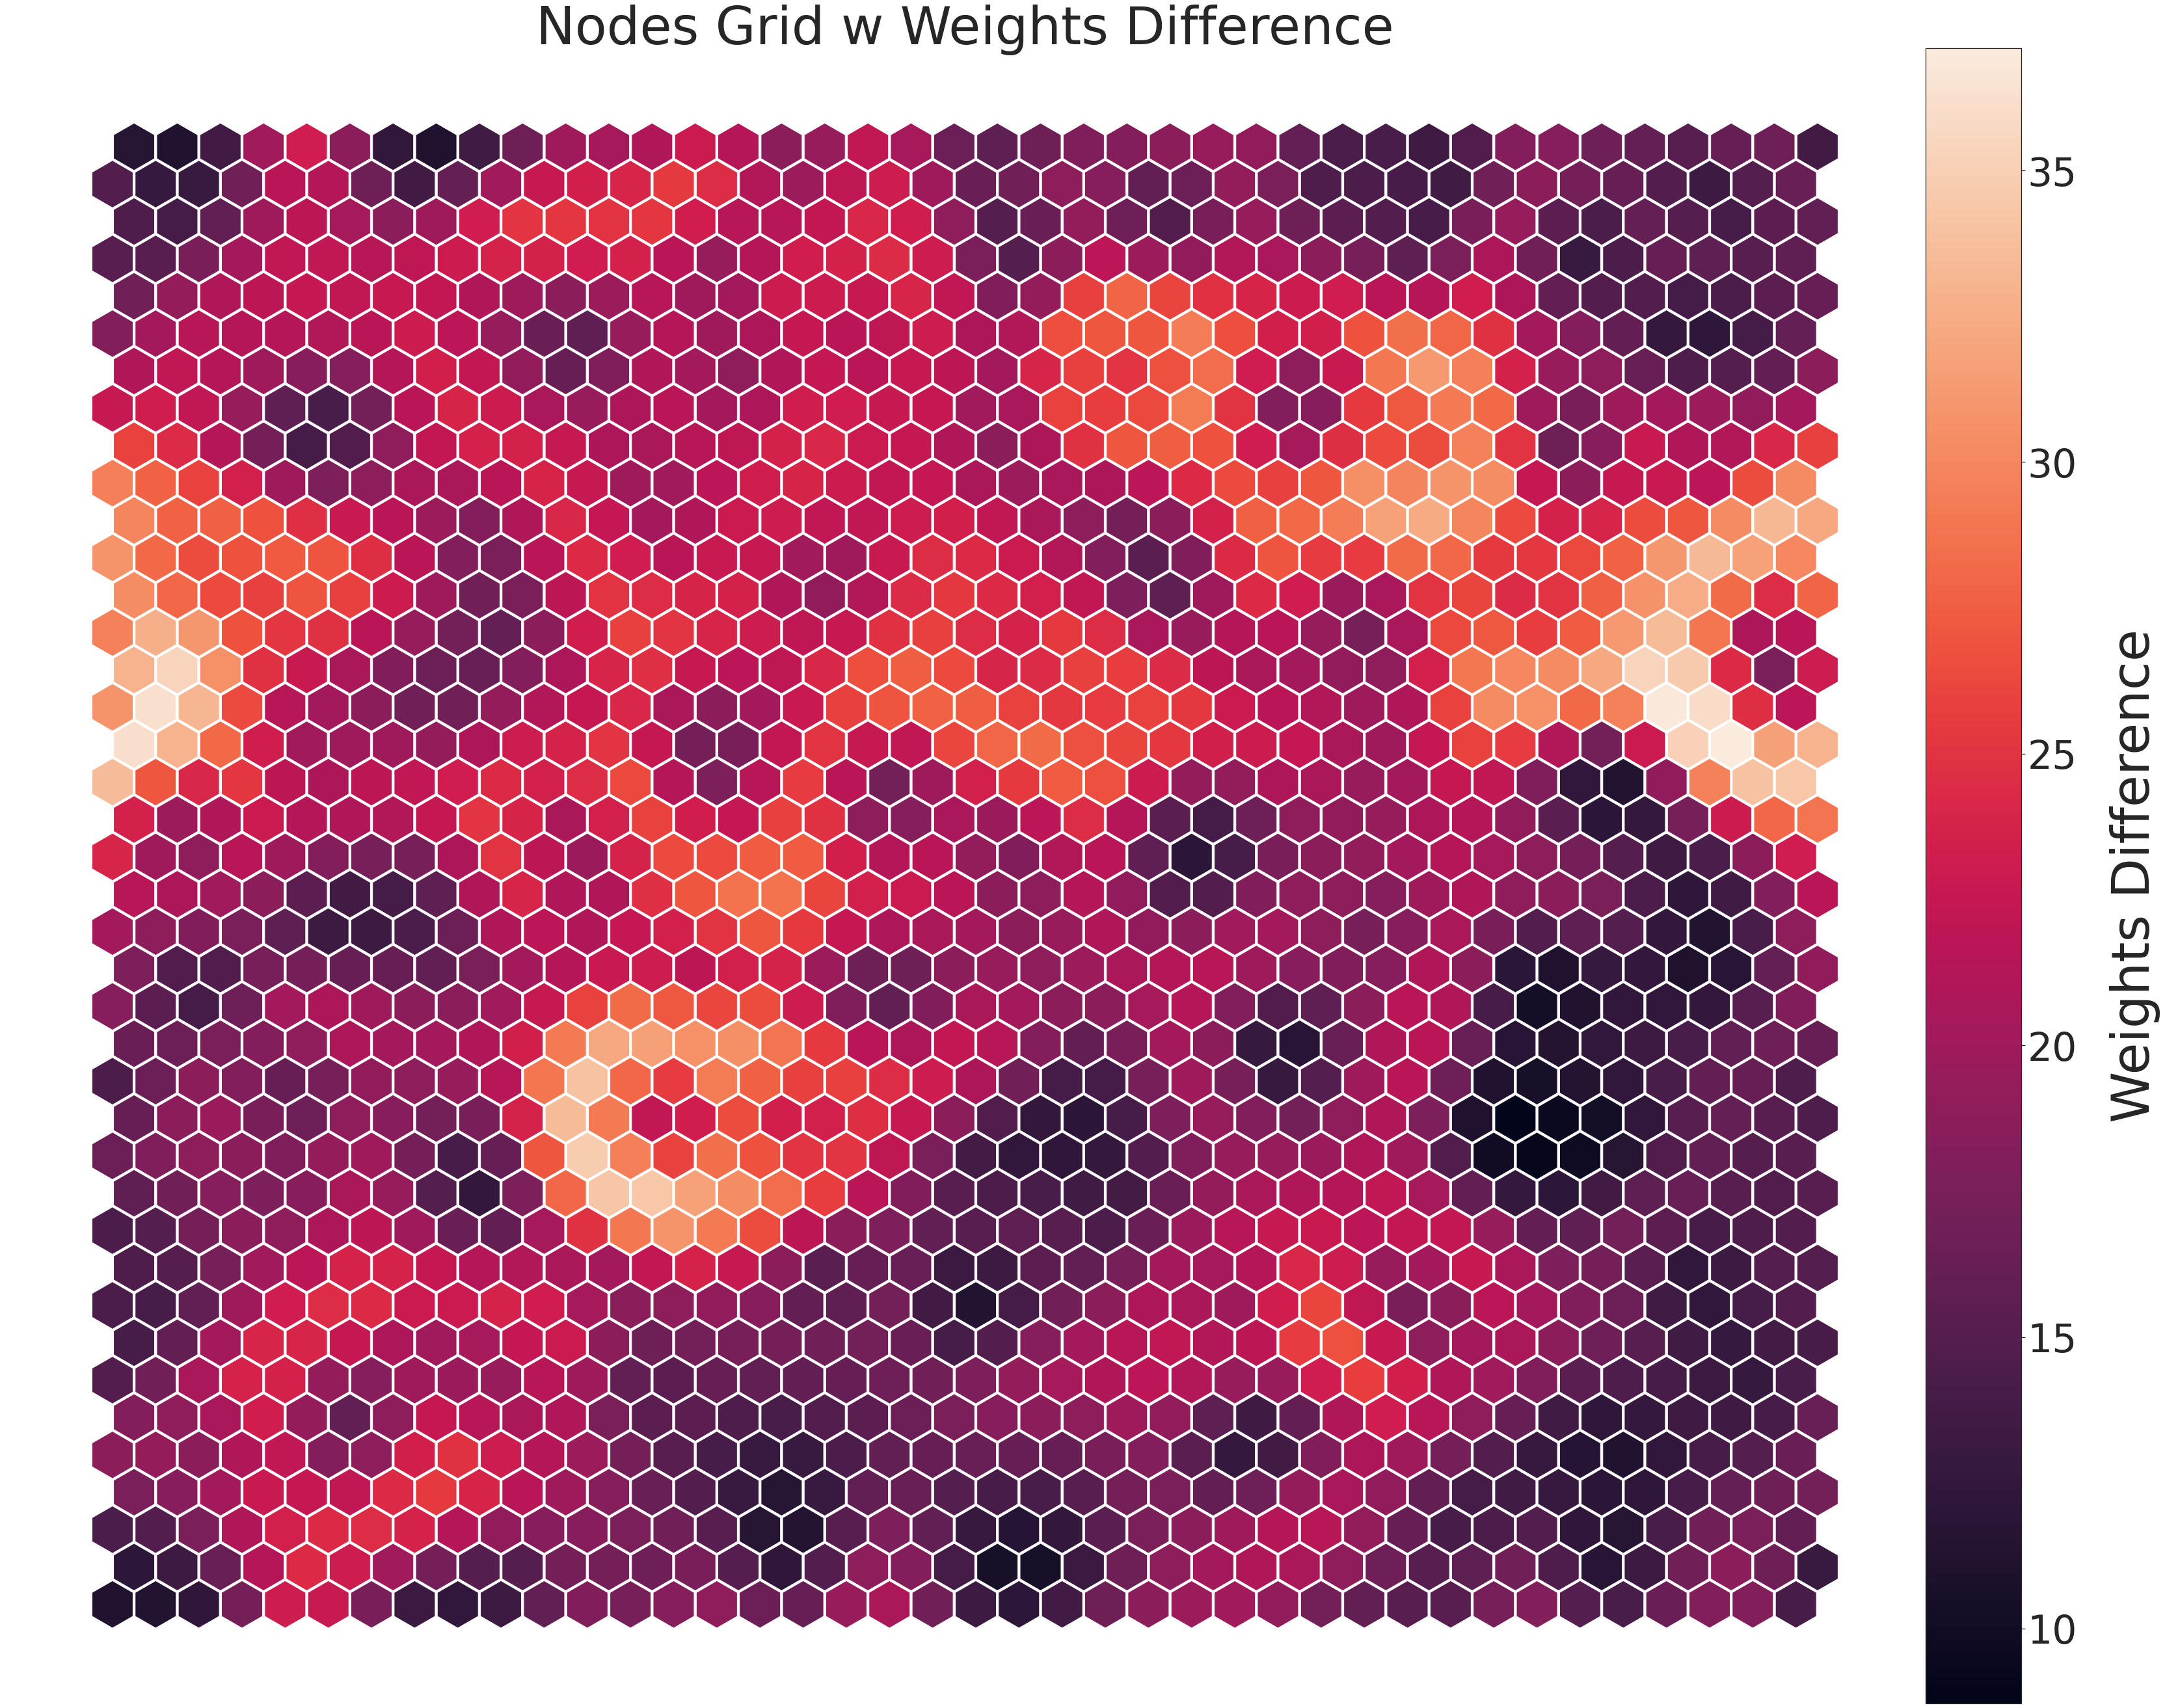

<Figure size 432x288 with 0 Axes>

In [18]:
#We build a 40x40 network and initialise its weights with PCA 
net = sps.somNet(40, 40, trainSt, PBC=True, PCI=True)

#Training the data set with a learning rate of .5 and 1000 epochs to make out model run faster
net.train(0.5, 1000)

#We print to screen the map of the weights differences between nodes, this will help us identify cluster centers 
net.diff_graph(show=True,printout=True)

The map above shows the weights of each node which are closer to gether or far apart. So the color ranges from dark blue to yellow where the dark blue is closer weights and yellow is weights far apart or different weights.
This allows us to cluster the data based on the dark points of the map.
The clusters are clearly seen from the above map and they are separated by the yellowish lighter area. The topoloy of the SOM is preserved and projected on to the map as show.

 The training time of SOM takes a lot of time so i had reduce the parameters to a minimum.

Node's position: 0 20


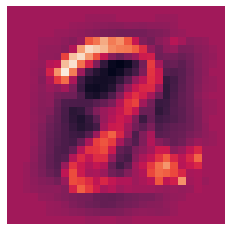

Node's position: 6 1


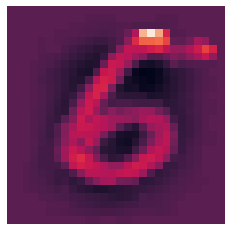

Node's position: 11 23


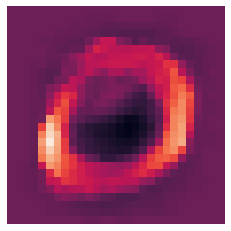

Node's position: 31 18


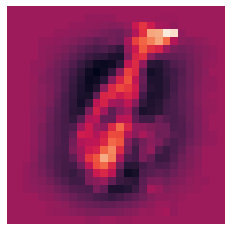

Node's position: 33 7


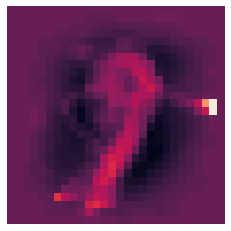

Node's position: 37 13


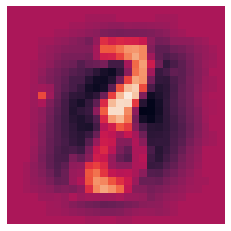

In [19]:
listNodes=[[20,0],[23,11],[1,6],[13,37],[7,33],[18,31]]
listCount=[posCount(20,0), posCount(23,11), posCount(1,6), posCount(13,37), posCount(7,33), posCount(18,31)]

i=0
for node in net.nodeList:
    if i in listCount:
        print('Node\'s position: {:d} {:d}'.format(posCountR(i)[1], posCountR(i)[0]) )
        plt.imshow(np.asarray(node.weights).reshape(28,28))
        plt.axis('off')
        plt.show()
    i+=1

Here we can see individual numbers with their weights. we can see then outline of each number slowly completing the number. We cmust use a slower learning rate and bigger epochs to make it more visible.

### Provide Report on tuning of hyper-parameters and accuracy of your model during training and testing
The hyperparameters used here are learning rate of .5 and an epochs of 1000 . The model works better with a lower learning rate and .1 and an epochs of 5000 and more. But the trade off is the time for it to complete. It took 60 mins with .5 and 1000 epochs. Better to use with low lr and high epochs.

### Use LSTM (RNN) to classify the MNIST data set.

In [ ]:
# Methods to classify the dataset using LSTM (RNN).
def create_model(num_classes_, input_shape_, learning_rate_, dropout_):
  # This model was based on reference [1][3][4][5].
  # Check if GPU is selected, for fast performance.  
  device_name = tf.test.gpu_device_name()
  if device_name != '/device:GPU:0':
    print('WARNING: GPU device not found.\n\n'
          'Change this in Notebook Settings via the '
          'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')

  # Create model
  model = tf.keras.Sequential(name="LSTM_model")

  model.add(tf.keras.Input(shape=input_shape_, name="Inputs"))
  model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, name="Rescaling"))
  
  # LSTM layer
  model.add(tf.keras.layers.LSTM(units=64, activation='tanh', name="LSTM_Layer"))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Dropout(dropout_))
  
  # Outcome
  model.add(tf.keras.layers.Dense(num_classes_, activation='softmax', name="Output"))

  model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate_),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
  
  print(model.summary())
  
  return model


def train_model(model_, Xtrain_df_, ytrain_df_, epochs_=1, batch_size_=None, validation_split_=0.1):
  
  history = model_.fit(
      x = Xtrain_df_, 
      y = ytrain_df_, 
      batch_size = batch_size_,
      epochs = epochs_, 
      validation_split = validation_split_,
      verbose = 2,
      shuffle = True) 

  # Values from train dataset
  acc = history.history['accuracy']
  loss = history.history['loss']

  # Values from validation dataset
  val_acc = history.history['val_accuracy']
  val_loss = history.history['val_loss']

  return acc, val_acc, loss, val_loss 


def evalua_model(model_, features_df_, label_df_):  
  # Evaluate the model
  test_loss, test_acc = model_.evaluate(features_df_,  label_df_, verbose=2)
  print('\nTest accuracy:', round(test_acc*100,2))


def plot_loss_curve(epchos_, acc_, val_acc_, loss_, val_loss_):
  
  epochs_range = range(epchos_)

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(epochs_range, acc_, label='Training Accuracy')
  plt.plot(epochs_range, val_acc_, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(epochs_range, loss_, label='Training Loss')
  plt.plot(epochs_range, val_loss_, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

HYPER-PARAMETERS
Input size (28, 28)
Classes 10
Learning rate 0.05
Dropout rate 0.5
Epchos 10
Batch size 1000
Validation split 0.2

Model: "LSTM_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Rescaling (Rescaling)        (None, 28, 28)            0         
_________________________________________________________________
LSTM_Layer (LSTM)            (None, 64)                23808     
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
Output (Dense)               (None, 10)                650       
Total params: 24,714
Trainable params: 24,586
Non-trainable params: 128
__________________________________________________

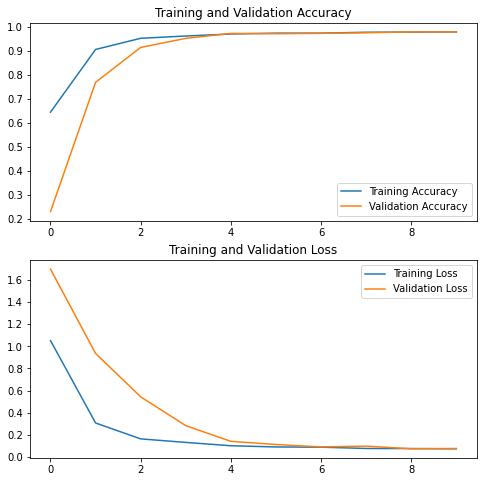

313/313 - 1s - loss: 0.0778 - accuracy: 0.9751

Test accuracy: 97.51


In [ ]:
# Hyperparamters
num_classes = 10
input_shape = x_train.shape[1:]
learning_rate = 0.05
dropout_rate = 0.5

epchos = 10 
batch_size = 1000
validation_split = 0.2

print("=================================================================")
print("HYPER-PARAMETERS")
print("Input size", input_shape)
print("Classes", num_classes)
print("Learning rate", learning_rate)
print("Dropout rate", dropout_rate)
print("Epchos", epchos)
print("Batch size", batch_size)
print("Validation split", validation_split)
print("=================================================================", end='\n\n')

# Starting process...
# Build the model
my_model = create_model(num_classes, input_shape, learning_rate, dropout_rate)
# Train the model
acc, val_acc, loss, val_loss = train_model(my_model, x_train, y_train, epchos, batch_size, validation_split)
# Plot train and validation plots
plot_loss_curve(epchos, acc, val_acc, loss, val_loss)

# Evaluate the model
evalua_model(my_model, x_test, y_test)

**Comments on hyper-parameters, layers, and neurons**
- Adding more layers to the model leads to higher **loss function values** in the train and validation set.
- Between 60 to 70 **neurons** is a perfect number as higher or lower values delta values from train and validation assets are higher.
Learning rates between 0.05 and 0.001 make the model have a lower loss function value.
- The **regularization** technique selected was the **dropout**. The rate was defined after the LSTM layer with a value of 0.5.

### Compare the results of SOM and LSTM 
In Self Organizing Map (SOM) we can only see the clusters with no labels, so finding out clusters that have similar features are the results of SOM (basically clustering which uses weights to map the input to a smaller output map). LSTM is a semi-supervised learning algorithm, which computes the probability an input is in classes (by using Softmax in the model) and an accuracy value roughly on test 98%.

## References
[1]. https://www.tensorflow.org/guide/keras/rnn

[2]. https://keras.io/api/layers/recurrent_layers/lstm/

[3]. https://analyticsindiamag.com/how-to-code-your-first-lstm-network-in-keras/

[4]. https://datascienceplus.com/long-short-term-memory-lstm-and-how-to-implement-lstm-using-python/

[5]. https://machinelearningmastery.com/how-to-develop-rnn-models-for-human-activity-recognition-time-series-classification/

[6]. https://stats.stackexchange.com/questions/21222/are-mean-normalization-and-feature-scaling-needed-for-k-means-clustering

[7]. https://developers.google.com/machine-learning/clustering/prepare-data

[8]. https://www.kaggle.com/asparago/unsupervised-learning-with-som/comments

[9]. https://realpython.com/k-means-clustering-python/

[10]. https://www.kaggle.com/thebrownviking20/clustering-images-w-neural-network-bayesian-opt

[11]. https://www.analyticsvidhya.com/blog/2019/05/beginners-guide-hierarchical-clustering/